In [4]:
import pandas as pd
import os

input_dir = "../data_clean/"

In [5]:
df_person = pd.read_pickle(os.path.join(input_dir, 'df_person.pkl'))
df_bio = pd.read_pickle(os.path.join(input_dir, 'df_bio.pkl'))
df_note = pd.read_pickle(os.path.join(input_dir, 'df_note.pkl'))
df_visit = pd.read_pickle(os.path.join(input_dir, 'df_visit.pkl'))
df_condition = pd.read_pickle(os.path.join(input_dir, 'df_condition.pkl'))

df_person.info()

<class 'pandas.core.frame.DataFrame'>
Index: 959 entries, 0 to 993
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   birth_datetime       940 non-null    datetime64[ns]
 1   death_datetime       549 non-null    datetime64[ns]
 2   gender_source_value  940 non-null    object        
 3   person_id            959 non-null    float64       
 4   prob                 37 non-null     float64       
dtypes: datetime64[ns](2), float64(2), object(1)
memory usage: 45.0+ KB


## Histogramme des âges des patients

Nous allons visualiser la distribution des âges des patients à partir de la colonne `birth_datetime`.

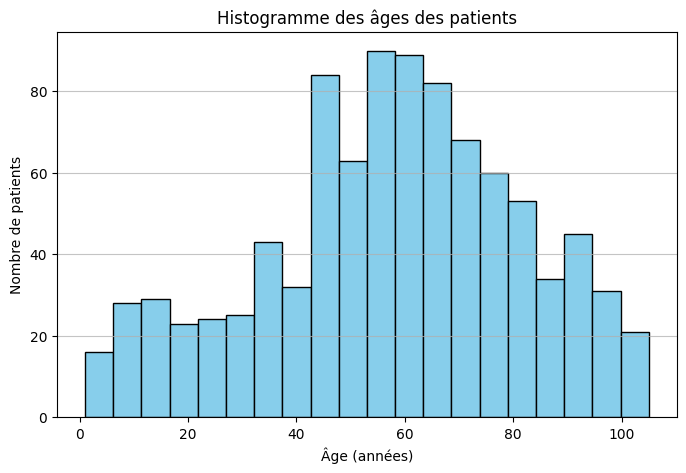

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Calculer l'âge à partir de la date de naissance
current_year = datetime.now().year
df_person = df_person.copy()
df_person = df_person[df_person['birth_datetime'].notna()]
df_person['age'] = current_year - df_person['birth_datetime'].dt.year

plt.figure(figsize=(8, 5))
plt.hist(df_person['age'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Âge (années)')
plt.ylabel('Nombre de patients')
plt.title('Histogramme des âges des patients')
plt.grid(axis='y', alpha=0.75)

output_dir = "../visuals/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
plt.savefig(os.path.join(output_dir, 'patients_age_histogram.png'))

plt.show()
